In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_folder = "/content/drive/MyDrive/indiv-datasets"

stocks = ["AAPL", "FB", "MSFT", "TSLA"]

In [4]:
def add_lag_features(df, target_col="Close", lags=[1,2,3], ma_windows=[3,5]):
    df = df.sort_values("Date").copy()

    for lag in lags:
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)

    for window in ma_windows:
        df[f"{target_col}_ma{window}"] = df[target_col].rolling(window).mean()

    df = df.dropna().reset_index(drop=True)
    return df


===== Training for AAPL =====

===== Training for FB =====

===== Training for MSFT =====

===== Training for TSLA =====


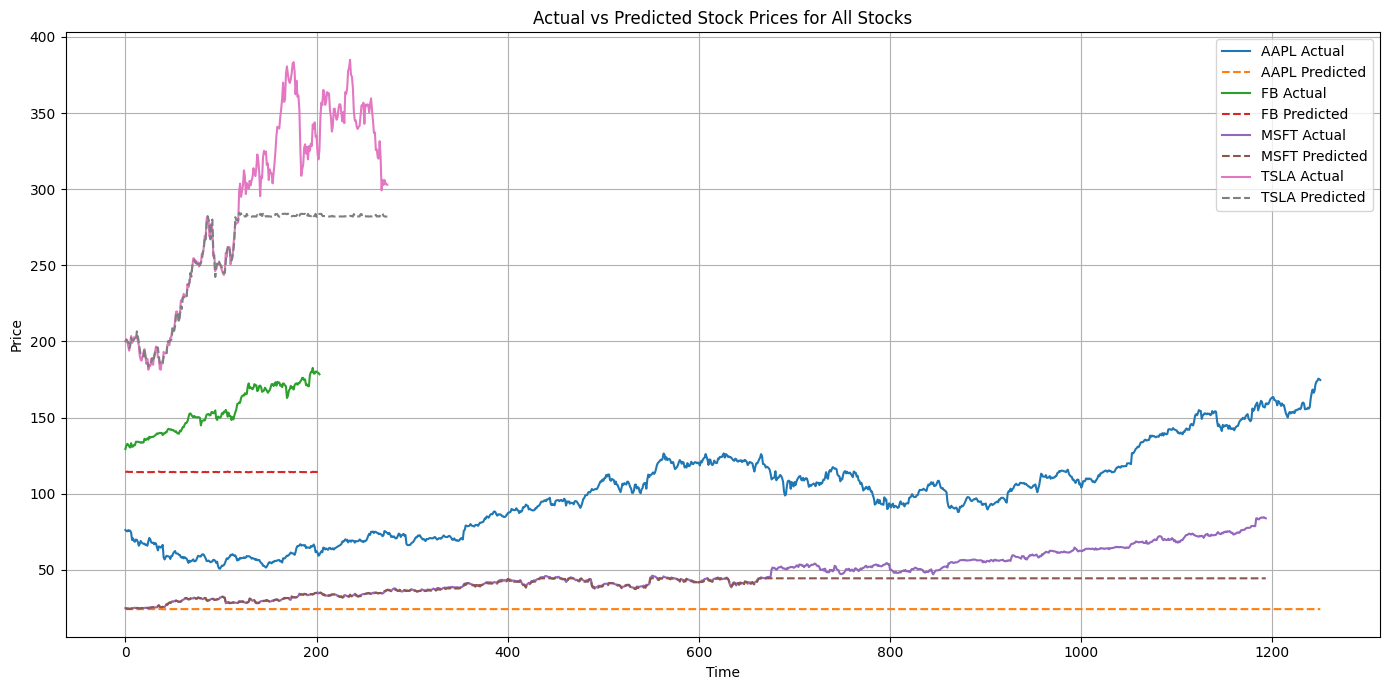

In [10]:
results = {}

plt.figure(figsize=(14, 7))

for stock in stocks:
    print(f"\n===== Training for {stock} =====")

    # Load CSVs
    train = pd.read_csv(os.path.join(data_folder, f"{stock}_Train.csv"))
    val   = pd.read_csv(os.path.join(data_folder, f"{stock}_Validation.csv"))
    test  = pd.read_csv(os.path.join(data_folder, f"{stock}_Test.csv"))

    # Add features
    train = add_lag_features(train)
    val   = add_lag_features(val)
    test  = add_lag_features(test)

    # Features & target
    feature_cols = ["Open", "High", "Low", "Volume"] + \
                   [col for col in train.columns if "lag" in col or "ma" in col]
    target_col = "Close"

    X_train, y_train = train[feature_cols], train[target_col]
    X_val,   y_val   = val[feature_cols],   val[target_col]
    X_test,  y_test  = test[feature_cols],  test[target_col]

    # Gradient Boosting + GridSearch
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "learning_rate": [0.05, 0.1],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    }

    gb = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=gb,
        param_grid=param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    # Metrics
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, y_pred)

    results[stock] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

    # Plot all stocks on same figure
    plt.plot(y_test.values, label=f"{stock} Actual", linewidth=1.5)
    plt.plot(y_pred, linestyle="--", label=f"{stock} Predicted", linewidth=1.5)

plt.title("Actual vs Predicted Stock Prices for All Stocks")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,R²
AAPL,76.195678,6661.690262,81.619178,-6.783497
FB,40.984242,1901.332689,43.604274,-7.587193
MSFT,7.064200,146.137400,12.088730,0.234985
TSLA,31.911024,2034.917048,45.110055,0.462774
